In [1]:
from typing import List

import gym
import sys
import copy

from xcsframework.xcs import *
from xcsframework.training import *
from xcsframework.xcsr import *


class CartPoleEnvironment(IEnvironment):

    def __init__(self):
        self._env = gym.make('CartPole-v1')
        self._end_of_problem = True
        self._current_state = None
        self.render = False

    def get_state(self) -> State[float]:
        if self._end_of_problem:
            observation = self._env.reset()
            self._current_state = self._get_state(observation)
            self._end_of_problem = False
        return self._current_state

    def get_available_actions(self) -> List[int]:
        return [0, 1]

    def execute_action(self, action: int) -> Number:
        if self.render:
            self._env.render()
        observation, _, done, _ = self._env.step(action)
        self._end_of_problem = done
        self._current_state = self._get_state(observation)

        return self._get_reward(observation, action)

    def is_end_of_problem(self) -> bool:
        return self._end_of_problem

    @staticmethod
    def _truncate(observation):
        ranges = [10, 0.418]
        values = observation / ranges
        for i in range(len(values)):
            if values[i] < MIN_VALUE:
                values[i] = MIN_VALUE
            elif values[i] > MAX_VALUE:
                values[i] = MAX_VALUE
        return values

    @staticmethod
    def _get_reward(observation, action):
        reward = 0
        pole_angle = observation[2]

        if pole_angle * (action - 0.5) >= 0.0:
            reward = 0.8

        # keep it close to 0 degrees
        if abs(pole_angle) < 0.07:
            reward += 0.2

        return reward

    @staticmethod
    def _get_state(observation):
        values = np.array([observation[1], observation[2]])
        return State(CartPoleEnvironment._truncate(values))


def print_population(population, amount: int = 0):
    """
    Prints a population.
    """
    sorted_population = sorted(population, key=lambda cl: -cl.experience)
    txt = ""
    if 0 < amount < population.numerosity_sum():
        txt = f" (showing {amount} most experienced classifier)"
    print(f"\nPopulation with size: {population.numerosity_sum()} {txt} :")
    for i, cl in enumerate(sorted_population):
        if 0 < amount < i:
            break
        print(f"   {cl}")


def validate(xcs, environment, iterations):
    reward_history = []
    reward_epoch = []
    for iteration in range(iterations):
        state = environment.get_state()
        action = xcs.query(state=state)
        reward = environment.execute_action(action)
        reward_epoch.append(reward)
        end_of_problem = environment.is_end_of_problem()
        if end_of_problem:
            reward_history.append(reward_epoch)
            reward_epoch = []
            return reward_history

    return reward_history


# ---------------------------------------------------------------------------------------------------------------------
# PROBLEM PARAMETERS
#
# the length of the input. larger inputs lead to increased runtime and complexity

# value range
MIN_VALUE = -1.0
MAX_VALUE = 1.0

# ---------------------------------------------------------------------------------------------------------------------
# TRAINING PARAMETERS
#
# after how many training iterations validation will be done
BATCH_SIZE = 195

# how many epochs will be done. total iterations = epochs * batch_size
EPOCHS = 2000

# validation size
VALIDATION_SIZE = 195

# the reward received for correct classification
MAX_REWARD = 1

# ---------------------------------------------------------------------------------------------------------------------
# XCS SPECIFIC PARAMETERS
#
# error threshold under which a classifier is considered to be accurate in its prediction
EPSILON_ZERO = sys.float_info.epsilon

# maximum classifier count
POPULATION_SIZE = 30

# probability for doing crossover in GA
CROSSOVER_PROBABILITY = 0.7

# what kind of crossover method to use in GA
CROSSOVER_METHOD = GAConstants.CrossoverMethod.UNIFORM

# whether bounds will be truncated into range [min_value, max_value]
TRUNCATE_TO_RANGE = True

# learning rate for parameter update
LEARNING_RATE = 0.03

# fitness parameter for updating values
FITNESS_ALPHA = 0.03

# mutate action in the GA. this leads to better results in this example
MUTATE_ACTION = True

# probability of mutations
MUTATION_RATE = 0.05

# how much mutation changes the value at most
MAX_MUTATION_CHANGE = 0.5

In [2]:
# 1. creating the environment
environment = CartPoleEnvironment()

# 2. instantiating constants (hyper parameters) and customizing values
learning_constants = LearningConstants(beta=LEARNING_RATE, epsilon_zero=EPSILON_ZERO)
fitness_constants = FitnessConstants(alpha=FITNESS_ALPHA)
covering_constants = XCSRCoveringConstants(max_spread=2.0,
                                           min_value=MIN_VALUE,
                                           max_value=MAX_VALUE,
                                           truncate_to_range=TRUNCATE_TO_RANGE)
ga_constants = GAConstants(crossover_probability=CROSSOVER_PROBABILITY,
                           mutate_action=MUTATE_ACTION,
                           mutation_rate=MUTATION_RATE,
                           crossover_method=CROSSOVER_METHOD)
ga_constants_r = XCSRGAConstants(ga_constants=ga_constants,
                                 min_value=MIN_VALUE,
                                 max_value=MAX_VALUE,
                                 truncate_to_range=TRUNCATE_TO_RANGE,
                                 max_mutation_change=MAX_MUTATION_CHANGE)

# 3. creating xcs components
covering_component = OBCoveringComponent(covering_constants=covering_constants)
learning_component = QLearningBasedComponent(learning_constants=learning_constants,
                                             fitness_constants=fitness_constants)
discovery_component = OBGeneticAlgorithm(available_actions=environment.get_available_actions(),
                                         ga_constants=ga_constants_r)
performance_component = PerformanceComponent(min_diff_actions=len(environment.get_available_actions()),
                                             covering_component=covering_component,
                                             available_actions=environment.get_available_actions())

subsumption_criteria = SubsumptionCriteriaExperiencePrecision(max_epsilon=EPSILON_ZERO)

# 4. initialize empty population
population = Population(max_size=POPULATION_SIZE,
                        subsumption_criteria=subsumption_criteria)

xcs: XCS[float, int] = XCS(population=population,
                           performance_component=performance_component,
                           discovery_component=discovery_component,
                           learning_component=learning_component,
                           available_actions=environment.get_available_actions())

In [3]:
# 5.training
trainer = TrainerEnvironment()
best_population = xcs.population
best_avg_reward = 0
avg_history = []

for epoch in range(EPOCHS):
    sys.stdout.write(f"\rEpoch {epoch + 1}/{EPOCHS}")
    trainer.optimize(xcs=xcs, environment=environment, training_iterations=BATCH_SIZE)
    environment._end_of_problem = True
    environment._env.close()

    # validation
    reward_history = validate(xcs, environment, VALIDATION_SIZE)
    avg_reward = average_reward(reward_history)
    avg_history.append(avg_reward)

    # remember best population
    if avg_reward > best_avg_reward:
        best_avg_reward = avg_reward
        best_population = copy.deepcopy(xcs.population)
    environment._end_of_problem = True
    environment._env.close()

    #print(f"\nAverage reward: {average_reward(reward_history):.1f}")
    #print("----------------------------------------------------------")

xcs._population = best_population

print(f"Best average reward: {best_avg_reward}")

# output the population
print_population(xcs.population, 20)

environment.render = True
reward_history = validate(xcs, environment, 400)
environment._end_of_problem = True
environment._env.close()
environment.render = False

Epoch 2000/2000Best average reward: 175.0

Population with size: 30  (showing 20 most experienced classifier) :
   [(-0.59 - 0.29)|(0.06 - 0.63)] --> 0, F:0.690, P:0.528, E:0.189, N:2, exp:310, AS:7.310
   [(-0.42 - -0.05)|(-0.05 - 0.07)] --> 1, F:0.365, P:1.461, E:0.285, N:1, exp:104, AS:7.967
   [(-0.42 - -0.05)|(-0.05 - 0.07)] --> 0, F:0.518, P:0.749, E:0.243, N:1, exp:61, AS:7.004
   [(-0.42 - 0.29)|(-0.19 - 0.69)] --> 1, F:0.151, P:1.157, E:0.315, N:2, exp:44, AS:5.685
   [(-0.59 - 0.29)|(0.06 - 0.63)] --> 1, F:0.403, P:1.256, E:0.274, N:2, exp:39, AS:4.867
   [(-0.42 - 1.00)|(-0.49 - 0.07)] --> 0, F:0.217, P:1.279, E:0.337, N:1, exp:30, AS:4.567
   [(-0.38 - 0.39)|(-0.49 - 0.07)] --> 1, F:0.018, P:0.946, E:0.441, N:1, exp:25, AS:7.720
   [(-0.42 - 1.00)|(-0.19 - 0.69)] --> 0, F:0.079, P:1.266, E:0.415, N:1, exp:25, AS:4.880
   [(-0.42 - 0.29)|(-0.49 - 0.07)] --> 0, F:0.208, P:1.392, E:0.318, N:1, exp:23, AS:4.435
   [(-0.38 - -0.05)|(-0.49 - 0.44)] --> 0, F:0.031, P:1.086, E:0.45

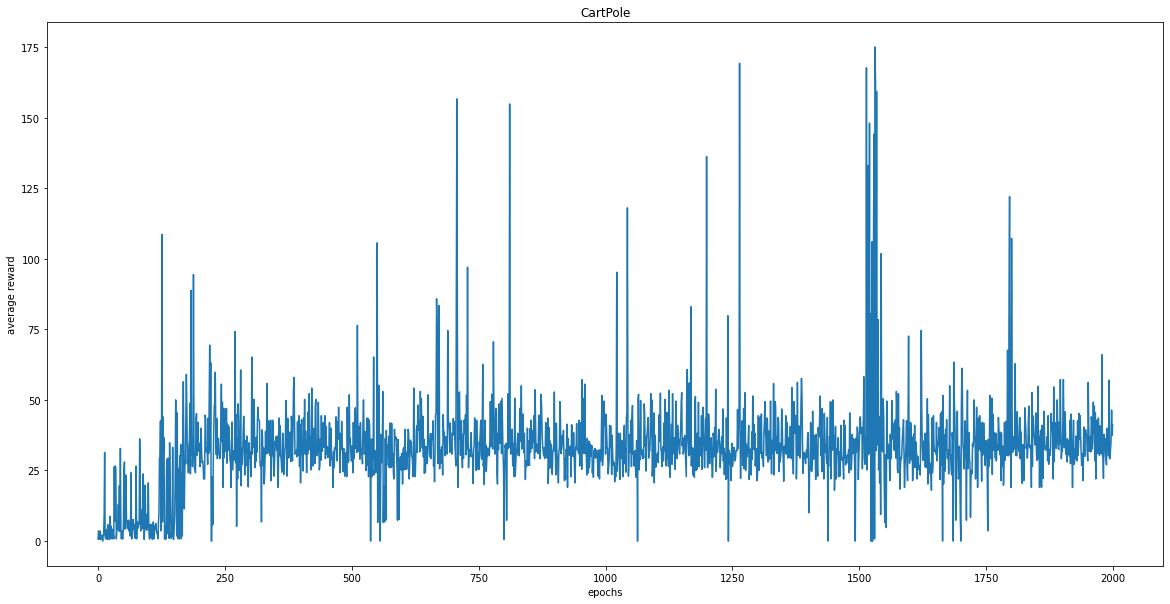

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_ylabel('average reward')
ax.set_xlabel('epochs')
ax.set_title('CartPole')
ax.plot(avg_history)